In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amparviz","key":"97a90f5556a57a44a5a44eba7d4b069b"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sbaghbidi/human-faces-object-detection

100% 498M/498M [00:25<00:00, 21.2MB/s]
100% 498M/498M [00:25<00:00, 20.2MB/s]


In [ ]:
!unzip human-faces-object-detection -d face_detection

Archive:  human-faces-object-detection.zip
  inflating: face_detection/faces.csv  
  inflating: face_detection/images/00000003.jpg  
  inflating: face_detection/images/00000004.jpg  
  inflating: face_detection/images/00000005.jpg  
  inflating: face_detection/images/00000006.jpg  
  inflating: face_detection/images/00000008.jpg  
  inflating: face_detection/images/00000011.jpg  
  inflating: face_detection/images/00000012.jpg  
  inflating: face_detection/images/00000015.jpg  
  inflating: face_detection/images/00000018.jpg  
  inflating: face_detection/images/00000020.jpg  
  inflating: face_detection/images/00000022.jpg  
  inflating: face_detection/images/00000023.jpg  
  inflating: face_detection/images/00000024.jpg  
  inflating: face_detection/images/00000026.jpg  
  inflating: face_detection/images/00000031.jpg  
  inflating: face_detection/images/00000032.jpg  
  inflating: face_detection/images/00000041.jpg  
  inflating: face_detection/images/00000044.jpg  
  inflating: face

In [ ]:
IMAGES_PATH = "/content/face_detection/images"
ANNOTS_PATH = "/content/face_detection/faces.csv"

In [ ]:
import tensorflow
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten , Dropout , Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
rows = open(ANNOTS_PATH).read().strip().split("\n")

targets = []
data = []

In [ ]:
for row in rows[1:]:

    row = row.split(",")
    (filename,h , w,  startX, startY, endX, endY )  = row

    imagePath = os.path.join(IMAGES_PATH , filename)
    image = cv2.imread(imagePath)
    # print(image)
    (h, w) = image.shape[:2]

    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = image/255
    data.append(image)
    targets.append((startX, startY, endX, endY))


In [ ]:
data = np.array(data, dtype="float32")
targets = np.array(targets, dtype="float32")


split = train_test_split(data, targets,  test_size=0.10, random_state=42)

(x_train, x_val) = split[:2]
(y_train, y_val) = split[2:4]

In [ ]:
split = train_test_split(x_val , y_val ,  test_size=0.10, random_state=42)

(x_val, x_test) = split[:2]
(y_val, y_test) = split[2:4]

In [ ]:
len(x_train)

3015

In [ ]:
len(x_val)

301

In [ ]:

len(x_test)

34

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

for layer in vgg.layers[:10]:
	layer.trainable = False
# vgg.trainable = False
out = vgg.output
# conv1 = Conv2D(50 , 2 , activation='relu' )(out)
flatten = Flatten()(out)


bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dropout(0.4)(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=vgg.input, outputs=bboxHead)

In [ ]:
def scheduler(epoch, lr):
     if epoch < 10:
         return lr

     else:
         return lr * np.exp(-0.5)

call_b1 = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)
call_b2 = tensorflow.keras.callbacks.ModelCheckpoint(save_best_only=True , filepath='/content/car-detector-model.h5' )


In [ ]:
import tensorflow
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32

opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer='sgd', metrics="accuracy")
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
H = model.fit(
    x_train , y_train,
    validation_data=(x_val , y_val),
    shuffle=True,
    callbacks=[call_b1 , call_b2],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    )

Epoch 1/10
95/95 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.6524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 35s 305ms/step - loss: 0.0349 - accuracy: 0.6524 - val_loss: 0.0282 - val_accuracy: 0.7874 - lr: 0.0100
Epoch 2/10
95/95 [==============================] - 22s 236ms/step - loss: 0.0295 - accuracy: 0.7327 - val_loss: 0.0273 - val_accuracy: 0.7874 - lr: 0.0100
Epoch 3/10
95/95 [==============================] - 28s 291ms/step - loss: 0.0278 - accuracy: 0.7459 - val_loss: 0.0261 - val_accuracy: 0.7874 - lr: 0.0100
Epoch 4/10
95/95 [==============================] - 27s 282ms/step - loss: 0.0266 - accuracy: 0.7400 - val_loss: 0.0251 - val_accuracy: 0.7874 - lr: 0.0100
Epoch 5/10
95/95 [==============================] - 27s 284ms/step - loss: 0.0254 - accuracy: 0.7529 - val_loss: 0.0241 - val_accuracy: 0.7940 - lr: 0.0100
Epoch 6/10
95/95 [==============================] - 29s 304ms/step - loss: 0.0244 - accuracy: 0.7519 - val_loss: 0.0231 - val_accuracy: 0.7841 - lr: 0.0100
Epoch 7/10
95/95 [==============================] - 28s 300ms/step - loss: 

In [ ]:
model = tensorflow.keras.models.load_model('/content/car-detector-model.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

1/1 [==============================] - 0s 237ms/step
(239, 182) (356, 370)


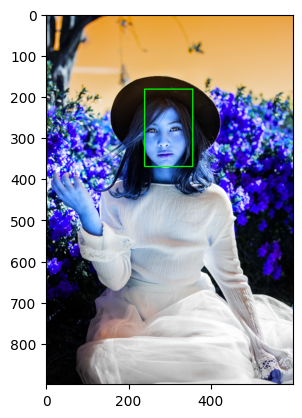

In [31]:
imagePath = "/content/face_detection/images/00000006.jpg"


image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds


image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print((startX, startY), (endX, endY))

cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)


plt.imshow(image)

In [ ]:
train_loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

In [ ]:
keras_sk_reg = KerasRegressor(build_fn=model)

learn_rate = [0.001, 0.01, 0.1]
momentum = [ 0.2, 0.4, 0.6]

param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum  )

keras_sk_reg_gs = GridSearchCV(keras_sk_reg, param_grid, cv=3)
keras_sk_reg_gs.fit(x_train[:500], y_train[:500], epochs=5, batch_size=16 , validation_data=(x_val, y_val), callbacks=[keras.callbacks.EarlyStopping(patience=3), call_b2])


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 26s 409ms/step - loss: 0.0451 - accuracy: 0.4985 - val_loss: 0.0302 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 3s 165ms/step - loss: 0.0321 - accuracy: 0.7177 - val_loss: 0.0298 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 3s 160ms/step - loss: 0.0301 - accuracy: 0.7327 - val_loss: 0.0288 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 3s 160ms/step - loss: 0.0293 - accuracy: 0.6967 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 9s 526ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 5s 186ms/step - loss: 0.0478 - accuracy: 0.4745 - val_loss: 0.0344 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 4s 171ms/step - loss: 0.0343 - accuracy: 0.6547 - val_loss: 0.0318 - val_accuracy: 0.7841
Epoch 3/5
21/21 [==============================] - 4s 171ms/step - loss: 0.0319 - accuracy: 0.6727 - val_loss: 0.0294 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 3s 168ms/step - loss: 0.0308 - accuracy: 0.7027 - val_loss: 0.0290 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 129ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 12s 554ms/step - loss: 0.0465 - accuracy: 0.5090 - val_loss: 0.0311 - val_accuracy: 0.7741
Epoch 2/5
21/21 [==============================] - 4s 171ms/step - loss: 0.0333 - accuracy: 0.6737 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 173ms/step - loss: 0.0323 - accuracy: 0.7216 - val_loss: 0.0291 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 175ms/step - loss: 0.0314 - accuracy: 0.7365 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 3s 528ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 203ms/step - loss: 0.0443 - accuracy: 0.5165 - val_loss: 0.0305 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 175ms/step - loss: 0.0308 - accuracy: 0.6456 - val_loss: 0.0294 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 239ms/step - loss: 0.0300 - accuracy: 0.7027 - val_loss: 0.0291 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 5s 243ms/step - loss: 0.0289 - accuracy: 0.7387 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 141ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 5s 200ms/step - loss: 0.0456 - accuracy: 0.5105 - val_loss: 0.0302 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 5s 242ms/step - loss: 0.0318 - accuracy: 0.7027 - val_loss: 0.0297 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 243ms/step - loss: 0.0321 - accuracy: 0.7207 - val_loss: 0.0286 - val_accuracy: 0.7841
Epoch 4/5
21/21 [==============================] - 4s 183ms/step - loss: 0.0310 - accuracy: 0.6577 - val_loss: 0.0286 - val_accuracy: 0.7841
Epoch 5/5
6/6 [==============================] - 1s 141ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 204ms/step - loss: 0.0493 - accuracy: 0.4880 - val_loss: 0.0301 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0332 - accuracy: 0.7096 - val_loss: 0.0294 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 247ms/step - loss: 0.0327 - accuracy: 0.7425 - val_loss: 0.0291 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 190ms/step - loss: 0.0314 - accuracy: 0.7246 - val_loss: 0.0287 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 5s 206ms/step - loss: 0.0460 - accuracy: 0.4685 - val_loss: 0.0319 - val_accuracy: 0.7741
Epoch 2/5
21/21 [==============================] - 5s 244ms/step - loss: 0.0317 - accuracy: 0.6967 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 186ms/step - loss: 0.0294 - accuracy: 0.7327 - val_loss: 0.0289 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0283 - accuracy: 0.7327 - val_loss: 0.0284 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 136ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 262ms/step - loss: 0.0467 - accuracy: 0.5015 - val_loss: 0.0310 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 5s 241ms/step - loss: 0.0330 - accuracy: 0.6787 - val_loss: 0.0301 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 244ms/step - loss: 0.0311 - accuracy: 0.6727 - val_loss: 0.0294 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0301 - accuracy: 0.6727 - val_loss: 0.0283 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 268ms/step - loss: 0.0479 - accuracy: 0.5269 - val_loss: 0.0303 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 187ms/step - loss: 0.0338 - accuracy: 0.6826 - val_loss: 0.0300 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 190ms/step - loss: 0.0336 - accuracy: 0.7006 - val_loss: 0.0289 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 193ms/step - loss: 0.0315 - accuracy: 0.6916 - val_loss: 0.0285 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 137ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 5s 200ms/step - loss: 0.0436 - accuracy: 0.4955 - val_loss: 0.0307 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 181ms/step - loss: 0.0325 - accuracy: 0.6757 - val_loss: 0.0296 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 246ms/step - loss: 0.0300 - accuracy: 0.7387 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 186ms/step - loss: 0.0289 - accuracy: 0.7387 - val_loss: 0.0288 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 143ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 218ms/step - loss: 0.0463 - accuracy: 0.5045 - val_loss: 0.0306 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0326 - accuracy: 0.6697 - val_loss: 0.0298 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 246ms/step - loss: 0.0324 - accuracy: 0.6997 - val_loss: 0.0297 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 5s 250ms/step - loss: 0.0308 - accuracy: 0.6787 - val_loss: 0.0295 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 142ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 262ms/step - loss: 0.0487 - accuracy: 0.4671 - val_loss: 0.0307 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 187ms/step - loss: 0.0329 - accuracy: 0.7186 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0315 - accuracy: 0.7485 - val_loss: 0.0287 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 187ms/step - loss: 0.0316 - accuracy: 0.7425 - val_loss: 0.0285 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 143ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 209ms/step - loss: 0.0458 - accuracy: 0.5255 - val_loss: 0.0313 - val_accuracy: 0.7774
Epoch 2/5
21/21 [==============================] - 5s 244ms/step - loss: 0.0310 - accuracy: 0.6757 - val_loss: 0.0290 - val_accuracy: 0.7841
Epoch 3/5
21/21 [==============================] - 5s 247ms/step - loss: 0.0287 - accuracy: 0.7177 - val_loss: 0.0285 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 192ms/step - loss: 0.0283 - accuracy: 0.7327 - val_loss: 0.0285 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 138ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 270ms/step - loss: 0.0480 - accuracy: 0.4775 - val_loss: 0.0326 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 242ms/step - loss: 0.0335 - accuracy: 0.6697 - val_loss: 0.0296 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0316 - accuracy: 0.6967 - val_loss: 0.0292 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 189ms/step - loss: 0.0299 - accuracy: 0.6937 - val_loss: 0.0290 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 290ms/step - loss: 0.0470 - accuracy: 0.5269 - val_loss: 0.0299 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 5s 248ms/step - loss: 0.0340 - accuracy: 0.6737 - val_loss: 0.0289 - val_accuracy: 0.7841
Epoch 3/5
21/21 [==============================] - 4s 189ms/step - loss: 0.0319 - accuracy: 0.7305 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 5s 250ms/step - loss: 0.0301 - accuracy: 0.7455 - val_loss: 0.0284 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 137ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 8s 277ms/step - loss: 0.0435 - accuracy: 0.4955 - val_loss: 0.0304 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 5s 241ms/step - loss: 0.0311 - accuracy: 0.6967 - val_loss: 0.0292 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0296 - accuracy: 0.7237 - val_loss: 0.0295 - val_accuracy: 0.7841
Epoch 4/5
21/21 [==============================] - 4s 186ms/step - loss: 0.0289 - accuracy: 0.7177 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 135ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 277ms/step - loss: 0.0462 - accuracy: 0.4655 - val_loss: 0.0304 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 244ms/step - loss: 0.0326 - accuracy: 0.6787 - val_loss: 0.0297 - val_accuracy: 0.7841
Epoch 3/5
21/21 [==============================] - 4s 189ms/step - loss: 0.0315 - accuracy: 0.7147 - val_loss: 0.0292 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 5s 246ms/step - loss: 0.0307 - accuracy: 0.7267 - val_loss: 0.0291 - val_accuracy: 0.7841
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 275ms/step - loss: 0.0476 - accuracy: 0.5629 - val_loss: 0.0302 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 245ms/step - loss: 0.0332 - accuracy: 0.7305 - val_loss: 0.0290 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 243ms/step - loss: 0.0328 - accuracy: 0.6826 - val_loss: 0.0291 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 183ms/step - loss: 0.0316 - accuracy: 0.7216 - val_loss: 0.0289 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 217ms/step - loss: 0.0456 - accuracy: 0.4775 - val_loss: 0.0307 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 187ms/step - loss: 0.0311 - accuracy: 0.7087 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0299 - accuracy: 0.7387 - val_loss: 0.0289 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0286 - accuracy: 0.7477 - val_loss: 0.0285 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 216ms/step - loss: 0.0474 - accuracy: 0.4625 - val_loss: 0.0325 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 248ms/step - loss: 0.0333 - accuracy: 0.6607 - val_loss: 0.0294 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0322 - accuracy: 0.7027 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0301 - accuracy: 0.7057 - val_loss: 0.0282 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 137ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 273ms/step - loss: 0.0479 - accuracy: 0.4940 - val_loss: 0.0305 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 5s 242ms/step - loss: 0.0337 - accuracy: 0.6916 - val_loss: 0.0292 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 187ms/step - loss: 0.0320 - accuracy: 0.7425 - val_loss: 0.0292 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 186ms/step - loss: 0.0318 - accuracy: 0.7545 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 143ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 228ms/step - loss: 0.0447 - accuracy: 0.5195 - val_loss: 0.0310 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 244ms/step - loss: 0.0313 - accuracy: 0.7297 - val_loss: 0.0295 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 247ms/step - loss: 0.0298 - accuracy: 0.6967 - val_loss: 0.0289 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 194ms/step - loss: 0.0285 - accuracy: 0.6937 - val_loss: 0.0285 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 141ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5


21/21 [==============================] - 8s 278ms/step - loss: 0.0470 - accuracy: 0.4625 - val_loss: 0.0322 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 244ms/step - loss: 0.0328 - accuracy: 0.6637 - val_loss: 0.0298 - val_accuracy: 0.7841
Epoch 3/5
21/21 [==============================] - 4s 187ms/step - loss: 0.0313 - accuracy: 0.6817 - val_loss: 0.0295 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0308 - accuracy: 0.7177 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 136ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 275ms/step - loss: 0.0473 - accuracy: 0.4611 - val_loss: 0.0301 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 181ms/step - loss: 0.0338 - accuracy: 0.7156 - val_loss: 0.0292 - val_accuracy: 0.7807
Epoch 3/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0318 - accuracy: 0.7216 - val_loss: 0.0288 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 184ms/step - loss: 0.0298 - accuracy: 0.7994 - val_loss: 0.0282 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 288ms/step - loss: 0.0447 - accuracy: 0.4565 - val_loss: 0.0304 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 4s 182ms/step - loss: 0.0294 - accuracy: 0.7117 - val_loss: 0.0298 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0296 - accuracy: 0.7237 - val_loss: 0.0290 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 189ms/step - loss: 0.0281 - accuracy: 0.7628 - val_loss: 0.0289 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 144ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 7s 275ms/step - loss: 0.0451 - accuracy: 0.4775 - val_loss: 0.0300 - val_accuracy: 0.7841
Epoch 2/5
21/21 [==============================] - 5s 247ms/step - loss: 0.0321 - accuracy: 0.6727 - val_loss: 0.0294 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 5s 247ms/step - loss: 0.0311 - accuracy: 0.7057 - val_loss: 0.0286 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 191ms/step - loss: 0.0306 - accuracy: 0.7147 - val_loss: 0.0283 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 139ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
21/21 [==============================] - 6s 226ms/step - loss: 0.0473 - accuracy: 0.5090 - val_loss: 0.0304 - val_accuracy: 0.7874
Epoch 2/5
21/21 [==============================] - 5s 247ms/step - loss: 0.0346 - accuracy: 0.6856 - val_loss: 0.0292 - val_accuracy: 0.7874
Epoch 3/5
21/21 [==============================] - 4s 183ms/step - loss: 0.0331 - accuracy: 0.7335 - val_loss: 0.0283 - val_accuracy: 0.7874
Epoch 4/5
21/21 [==============================] - 4s 185ms/step - loss: 0.0298 - accuracy: 0.7096 - val_loss: 0.0281 - val_accuracy: 0.7874
Epoch 5/5
6/6 [==============================] - 1s 136ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
32/32 [==============================] - 10s 254ms/step - loss: 0.0418 - accuracy: 0.5580 - val_loss: 0.0303 - val_accuracy: 0.7874
Epoch 2/5
32/32 [==============================] - 6s 195ms/step - loss: 0.0314 - accuracy: 0.7160 - val_loss: 0.0295 - val_accuracy: 0.7874
Epoch 3/5
32/32 [==============================] - 6s 199ms/step - loss: 0.0311 - accuracy: 0.7080 - val_loss: 0.0293 - val_accuracy: 0.7874
Epoch 4/5
32/32 [==============================] - 5s 162ms/step - loss: 0.0293 - accuracy: 0.7320 - val_loss: 0.0282 - val_accuracy: 0.7874
Epoch 5/5
32/32 [==============================] - 5s 165ms/step - loss: 0.0289 - accuracy: 0.7360 - val_loss: 0.0279 - val_accuracy: 0.7874


GridSearchCV(cv=3,
             estimator=KerasRegressor(build_fn=<keras.src.engine.functional.Functional object at 0x7fb516fcb700>),
             param_grid={'optimizer__learning_rate': [0.001, 0.01, 0.1],
                         'optimizer__momentum': [0.2, 0.4, 0.6]})

In [ ]:
keras_sk_reg_gs.best_params_

{'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.6}

In [ ]:
keras_sk_reg_gs.best_score_

0.034238924685849624

In [ ]:
keras_sk_reg_gs.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'save'

In [ ]:
print("Best: %f using %s" % (keras_sk_reg_gs.best_score_, keras_sk_reg_gs.best_params_))
means = keras_sk_reg_gs.cv_results_['mean_test_score']
stds = keras_sk_reg_gs.cv_results_['std_test_score']
params = keras_sk_reg_gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.034239 using {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.6}
0.023933 (0.005332) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.013721 (0.011256) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.033178 (0.005341) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.010937 (0.014648) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.007884 (0.019390) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.020765 (0.009030) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.013717 (0.011606) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.2}
0.014354 (0.014057) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.4}
0.034239 (0.020879) with: {'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.6}


1/1 [==============================] - 0s 29ms/step
(216, 201) (362, 376)


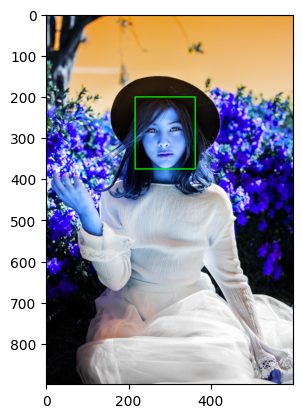

In [32]:
imagePath = "/content/face_detection/images/00000006.jpg"


image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
preds = keras_sk_reg_gs.predict(image)[0]
(startX, startY, endX, endY) = preds


image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print((startX, startY), (endX, endY))

cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)


plt.imshow(image)

In [33]:
ev = model.evaluate(x_test , y_test ,verbose=0)

In [34]:
print(f'Model loss is: {round(ev[0] , 2) * 100}% and Model accuracy is: {ev[1] * 100}%')

Model loss is: 2.0% and Model accuracy is: 85.29411554336548%
